# Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Downloaded data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip and unzipped

In [2]:
path='data/ml-latest-small/'

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
movies = pd.read_csv(path + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
val_idxs = get_cv_idxs(len(ratings))
weight_decay = 2e-4
n_factors = 50

In [9]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [12]:
learn.fit(1e-2, 2, wds=weight_decay, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.753395   0.778629  
    1      0.759393   0.779605                                  
    2      0.547174   0.765967                                  



[array([0.76597])]

In [15]:
math.sqrt(0.765967) # MSE -> RMSE

0.8751954067521149

In [16]:
preds = learn.predict()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


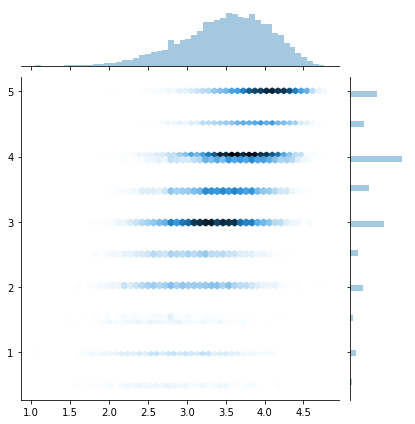

In [18]:
y = learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None)

## Results

### Movie bias

In [20]:
movie_names = movies.set_index('movieId')['title'].to_dict()
grouped_ratings = ratings.groupby('movieId')['rating'].count()
top_movies = grouped_ratings.sort_values(ascending=False).index.values[:3000]
top_movie_indexes = np.array([cf.item2idx[o] for o in top_movies])

In [22]:
model = learn.model
model.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [23]:
movie_bias = to_np(model.ib(V(top_movie_indexes)))

In [24]:
movie_bias

array([[ 0.76947],
       [ 0.8665 ],
       [ 1.31396],
       ...,
       [ 0.3117 ],
       [-0.04307],
       [ 0.20276]], dtype=float32)

In [26]:
movie_ratings = [(bias[0], movie_names[movie_index]) for movie_index, bias in zip(top_movies, movie_bias)]

In [28]:
sorted(movie_ratings, key=lambda o: o[0])[:15] # could also use itemgetter(0)

[(-1.0776231, 'Battlefield Earth (2000)'),
 (-0.86673975, 'Speed 2: Cruise Control (1997)'),
 (-0.8662862, 'Wild Wild West (1999)'),
 (-0.86360186, 'Anaconda (1997)'),
 (-0.7997283, 'Super Mario Bros. (1993)'),
 (-0.7814877, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.74982935, 'Hollow Man (2000)'),
 (-0.7296861, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.7223648, 'Police Academy 3: Back in Training (1986)'),
 (-0.7106202, 'Little Nicky (2000)'),
 (-0.7065485, 'Superman III (1983)'),
 (-0.6938987, 'Bio-Dome (1996)'),
 (-0.6899674, 'Batman & Robin (1997)'),
 (-0.6886244, 'Godzilla (1998)'),
 (-0.68608236, 'Jaws 3-D (1983)')]

In [29]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3139635, 'Shawshank Redemption, The (1994)'),
 (1.2636778, 'Godfather, The (1972)'),
 (1.123217, 'Usual Suspects, The (1995)'),
 (1.0288458, 'Godfather: Part II, The (1974)'),
 (0.97319937, 'Memento (2000)'),
 (0.9611202, 'Fargo (1996)'),
 (0.91683507, 'Princess Bride, The (1987)'),
 (0.90784216, 'Rear Window (1954)'),
 (0.89741546, "Schindler's List (1993)"),
 (0.89697903, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.88192046, '12 Angry Men (1957)'),
 (0.88017416, 'African Queen, The (1951)'),
 (0.876146, 'Dark Knight, The (2008)'),
 (0.8665023, 'Pulp Fiction (1994)'),
 (0.86631507, 'Lord of the Rings: The Return of the King, The (2003)')]

### Embeddings

In [30]:
movie_embeddings = to_np(model.i(V(top_movie_indexes)))

In [32]:
movie_embeddings.shape

(3000, 50)

Use principal component analysis to reduce dimensionality of the embedding matrix to make it easier to reason about

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_embeddings.T).components_

In [34]:
movie_pca.shape

(3, 3000)

In [35]:
movie_components = [(factor, movie_names[index]) for factor, index in zip(movie_pca[0], top_movies)]

In [36]:
sorted(movie_components, key=itemgetter(0))[:10]

[(-0.08435461, 'Armageddon (1998)'),
 (-0.080589935, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.06803209, 'Waterworld (1995)'),
 (-0.063456625, 'Coyote Ugly (2000)'),
 (-0.063263856, 'Lethal Weapon 4 (1998)'),
 (-0.061362047, 'Outbreak (1995)'),
 (-0.056602996, 'Pay It Forward (2000)'),
 (-0.055233374, 'Mission: Impossible II (2000)'),
 (-0.054409314, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.053334586, 'Entrapment (1999)')]

In [37]:
sorted(movie_components, key=itemgetter(0), reverse=True)[:10]

[(0.074797146, 'Pulp Fiction (1994)'),
 (0.07391271, 'Chinatown (1974)'),
 (0.07028457, 'Fargo (1996)'),
 (0.06443806, 'Taxi Driver (1976)'),
 (0.06387303, 'Apocalypse Now (1979)'),
 (0.06152945, 'Airplane! (1980)'),
 (0.059254516, 'Deer Hunter, The (1978)'),
 (0.058278184, 'Vertigo (1958)'),
 (0.057062283, "One Flew Over the Cuckoo's Nest (1975)"),
 (0.056787416, 'North by Northwest (1959)')]

In [38]:
movie_components = [(factor, movie_names[index]) for factor, index in zip(movie_pca[1], top_movies)]
[
    sorted(movie_components, key=itemgetter(0))[:10],
    sorted(movie_components, key=itemgetter(0), reverse=True)[:10]
]

[[(-0.07425137, 'Clue (1985)'),
  (-0.06742827, 'American Pie (1999)'),
  (-0.06737286, 'Office Space (1999)'),
  (-0.067068085, 'Chasing Amy (1997)'),
  (-0.06613617, 'Mr. & Mrs. Smith (2005)'),
  (-0.06594085, 'Austin Powers: International Man of Mystery (1997)'),
  (-0.06512271, 'Dark Knight, The (2008)'),
  (-0.06177146, 'Man Who Knew Too Little, The (1997)'),
  (-0.060744617, 'Mission: Impossible (1996)'),
  (-0.060646445, 'Scream (1996)')],
 [(0.0631004, 'Little Miss Sunshine (2006)'),
  (0.059490576, 'Slumdog Millionaire (2008)'),
  (0.05860042, 'The Imitation Game (2014)'),
  (0.05680472, 'Thomas Crown Affair, The (1999)'),
  (0.05630737, 'Great Dictator, The (1940)'),
  (0.055655085,
   'Triplets of Belleville, The (Les triplettes de Belleville) (2003)'),
  (0.055449236, 'Grand Budapest Hotel, The (2014)'),
  (0.052648142, 'Like Water for Chocolate (Como agua para chocolate) (1992)'),
  (0.052594934, 'In Bruges (2008)'),
  (0.05219281, 'Piano, The (1993)')]]

In [39]:
movie_components = [(factor, movie_names[index]) for factor, index in zip(movie_pca[2], top_movies)]
[
    sorted(movie_components, key=itemgetter(0))[:10],
    sorted(movie_components, key=itemgetter(0), reverse=True)[:10]
]

[[(-0.053616084, 'Space Jam (1996)'),
  (-0.050295167, 'Thin Red Line, The (1998)'),
  (-0.049719643, 'Transformers: Dark of the Moon (2011)'),
  (-0.049155172, "Joe's Apartment (1996)"),
  (-0.048558645, 'Lost Highway (1997)'),
  (-0.048389602, 'Leaving Las Vegas (1995)'),
  (-0.047259744, 'Scary Movie (2000)'),
  (-0.045740098, 'Howard the Duck (1986)'),
  (-0.04526269, "Singin' in the Rain (1952)"),
  (-0.04509039, 'Home Alone 2: Lost in New York (1992)')],
 [(0.11577925, 'Aladdin (1992)'),
  (0.10673451,
   'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
  (0.09471527, 'Austin Powers: The Spy Who Shagged Me (1999)'),
  (0.094142534, 'Lord of the Rings: The Return of the King, The (2003)'),
  (0.08480868, 'Lord of the Rings: The Two Towers, The (2002)'),
  (0.08162993, 'Star Wars: Episode IV - A New Hope (1977)'),
  (0.080238424, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
  (0.080206774, 'Star Wars: Episode VI - Return of the Jedi (1

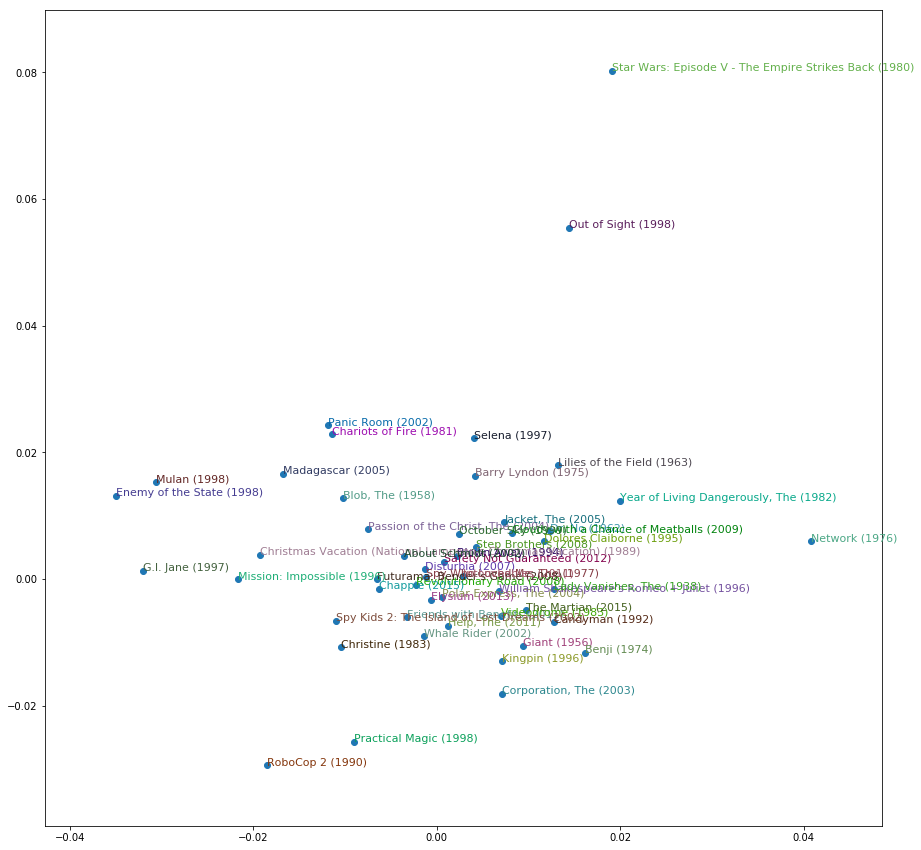

In [43]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
X = movie_pca[0][idxs]
Y = movie_pca[2][idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Writing from scratch

### Dot product example

In [44]:
a = T([[1., 2], [3, 4]])
b = T([[2., 2], [10, 10]])
a, b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [45]:
a * b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [46]:
(a * b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [47]:
class DotProduct(nn.Module):
    def forward(self, users, items): return (users * items).sum(1)

In [48]:
model = DotProduct()

In [49]:
model(a, b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [56]:
u_uniq = ratings.userId.unique()
user2idx = { user: index for index, user in enumerate(u_uniq) }
ratings.userId = ratings.userId.apply(lambda u: user2idx[u])

m_uniq = ratings.movieId.unique()
movie2idx = { movie: index for index, movie in enumerate(m_uniq) }
ratings.movieId = ratings.movieId.apply(lambda m: movie2idx[m])

n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())

In [73]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_items):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.item_embedding = nn.Embedding(n_items, n_factors)
        self.user_embedding.weight.data.uniform_(0, 0.05)
        self.item_embedding.weight.data.uniform_(0, 0.05)
        
    def forward(self, categorical, continuous):
        users = self.user_embedding(categorical[:, 0])
        items = self.item_embedding(categorical[:, 1])
        # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
        # => create tensor of dimensions [N, 1]
        return (users * items).sum(1).view(-1, 1)

In [74]:
x = ratings.drop(['rating', 'timestamp'], axis=1)
y = ratings['rating'].astype(np.float32)

In [75]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [76]:
weight_decay = 1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
optimization_function = optim.SGD(model.parameters(), 1e-1, weight_decay=weight_decay, momentum=0.9)

In [77]:
fit(model, data, 3, optimization_function, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.637472   1.630921  
    1      1.119543   1.296283                                 
    2      0.944328   1.233082                                  



[array([1.23308])]

In [78]:
set_lrs(optimization_function, 0.01)

In [79]:
fit(model, data, 3, optimization_function, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.745415   1.146078  
    1      0.703061   1.134854                                  
    2      0.690856   1.129812                                  



[array([1.12981])]

### Bias

In [80]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [84]:
def get_embedding(num_embeddings, embedding_dim):
    embedding = nn.Embedding(num_embeddings, embedding_dim)
    embedding.weight.data.uniform_(-0.01, 0.01)
    return embedding

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_items):
        super().__init__()
        self.user_embedding = get_embedding(n_users, n_factors)
        self.item_embedding = get_embedding(n_items, n_factors)
        self.user_bias = get_embedding(n_users, 1)
        self.item_bias = get_embedding(n_items, 1)

    def forward(self, cats, conts):
        users = cats[:,0]
        items = cats[:,1]
        dot_product = (self.user_embedding(users) * self.item_embedding(items)).sum(1)
        result = dot_product + self.user_bias(users).squeeze() + self.item_bias(items).squeeze()
        result = F.sigmoid(result) * (max_rating - min_rating) + min_rating
        return result.view(-1, 1)

In [85]:
weight_decay = 2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
optimization_function = optim.SGD(model.parameters(), 1e-1, weight_decay=weight_decay, momentum=0.9)

In [86]:
fit(model, data, 3, optimization_function, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.835574   0.837854  
    1      0.814447   0.819242                                  
    2      0.761914   0.809945                                  



[array([0.80994])]

In [87]:
set_lrs(optimization_function, 1e-2)

In [88]:
fit(model, data, 3, optimization_function, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.745315   0.801815  
    1      0.72043    0.800656                                  
    2      0.75119    0.800133                                  



[array([0.80013])]

## Mini net

In [104]:
# class EmbeddingNet(nn.Module):
#     def __init__(self, num_users, num_items, num_hidden_layers=10, dropout_1=0.05, dropout_2=0.5):
#         super().__init__()
#         self.users = get_embedding(num_users, n_factors)
#         self.items = get_embedding(num_items, n_factors)
#         self.layers = {}
#         self.layers['linear_1'] = nn.Linear(n_factors * 2, num_hidden_layers)
#         self.layers['linear_2'] = nn.Linear(num_hidden_layers, 1)
#         self.layers['dropout_1'] = nn.Dropout(dropout_1)
#         self.layers['dropout_2'] = nn.Dropout(dropout_2)
        
#     def forward(self, cats, foo):
#         users = cats[:,0]
#         items = cats[:,1]
#         x = self.layers['dropout_1'](torch.cat([self.users(users), self.items(items)], dim=1))
#         x = self.layers['dropout_2'](F.relu(self.layers['linear_1'](x)))
#         return F.sigmoid(self.layers['linear_2'](x)) * (max_rating - min_rating + 1) + min_rating + 0.5

class EmbeddingNet(nn.Module):
    def __init__(self, num_users, num_items, num_hidden_layers=10, dropout_1=0.05, dropout_2=0.5):
        super().__init__()
        self.users = get_embedding(num_users, n_factors)
        self.items = get_embedding(num_items, n_factors)
        self.layers = {}
        self.linear_1 = nn.Linear(n_factors * 2, num_hidden_layers)
        self.linear_2 = nn.Linear(num_hidden_layers, 1)
        self.dropout_1 = nn.Dropout(dropout_1)
        self.dropout_2 = nn.Dropout(dropout_2)
        
    def forward(self, cats, foo):
        users = cats[:,0]
        items = cats[:,1]
        x = self.dropout_1(torch.cat([self.users(users), self.items(items)], dim=1))
        x = self.dropout_2(F.relu(self.linear_1(x)))
        return F.sigmoid(self.linear_2(x)) * (max_rating - min_rating + 1) + min_rating + 0.5

In [107]:
weight_decay = 1e-5
model = EmbeddingNet(cf.n_users, cf.n_items).cuda()
optimization_function = optim.Adam(model.parameters(), 1e-3, weight_decay=weight_decay)

In [109]:
fit(model, data, 3, optimization_function, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.812726   0.790184  
    1      0.741602   0.792036                                  
    2      0.761467   0.795047                                  



[array([0.79505])]